In [16]:
import fmdtools.sim.propagate as propagate
import fmdtools.analyze as an
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Urban Drone Demo
## Model Overview
The drone model is defined in `drone_mdl_urban.py`, along with some visualization functions.

In [17]:
from drone_mdl_urban import Drone

In [18]:
mdl = Drone()

This is the model structure:

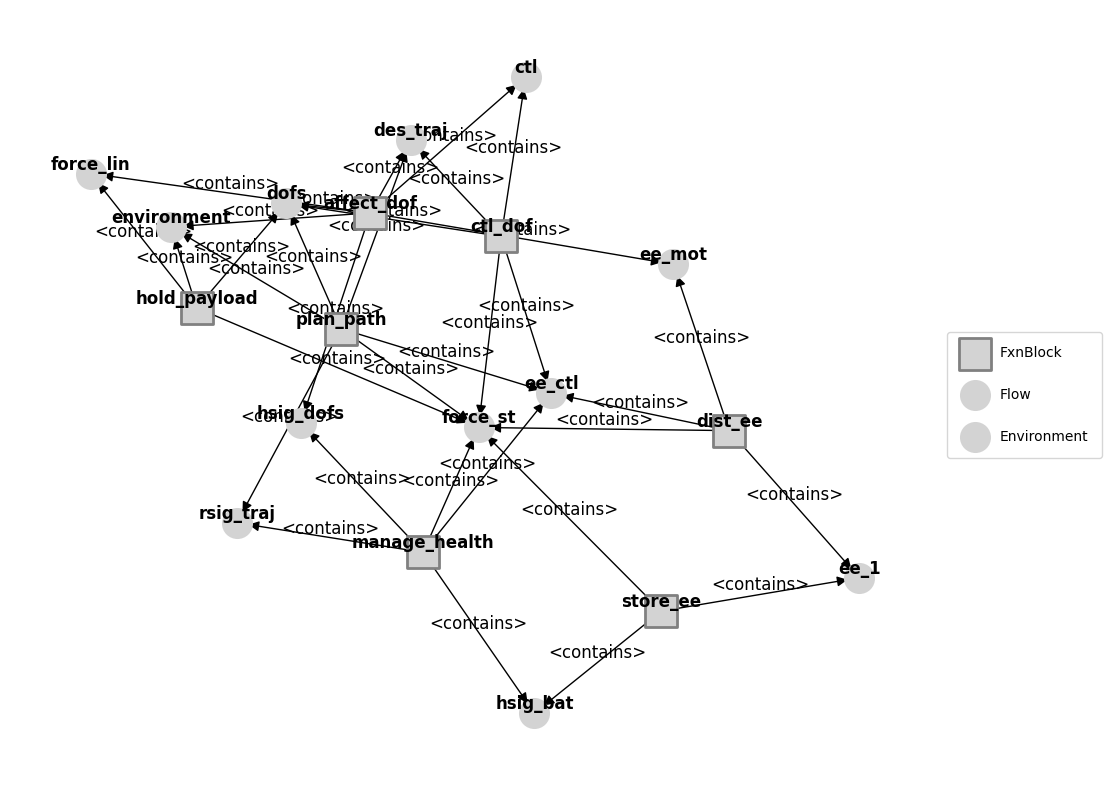

In [19]:
mg = an.graph.ModelGraph(mdl)
fig, ax = mg.draw()

We can also view the grid environment using methods in the `analyze.show` module:

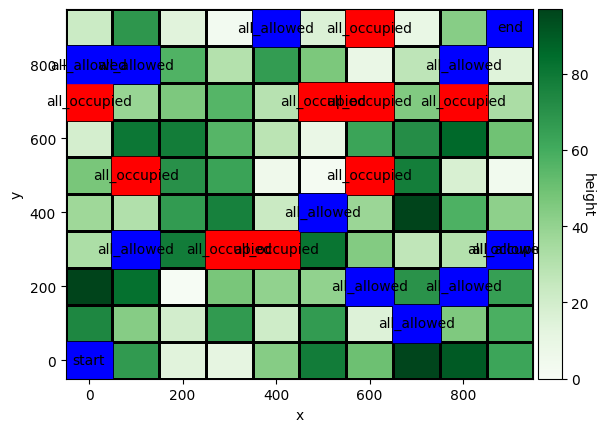

In [20]:
fig, ax = an.show.coord(mdl.flows['environment'].c, "height",
                        collections={"all_occupied": {"color": "red"},
                                     "all_allowed": {"color": "blue"},
                                     "start": {"color": "blue"},
                                     "end": {"color": "blue"}})

Which shows the Start, End, and allowed/unsafe locations in the 1000x1000-m grid. In this display, line thickness corresponds to building height, and hatching corresponds to whether or not the space is occupied. We can also display this using `show.coord3d`:

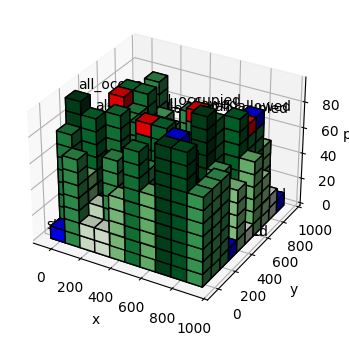

In [21]:
fig, ax = an.show.coord3d(mdl.flows['environment'].c, "height",
                        collections={"all_occupied": {"color": "red"},
                                     "all_allowed": {"color": "blue"},
                                     "start": {"color": "blue"},
                                     "end": {"color": "blue"}})

## Nominal Simulation

Below we show how this drone performs in the nominal scenario.

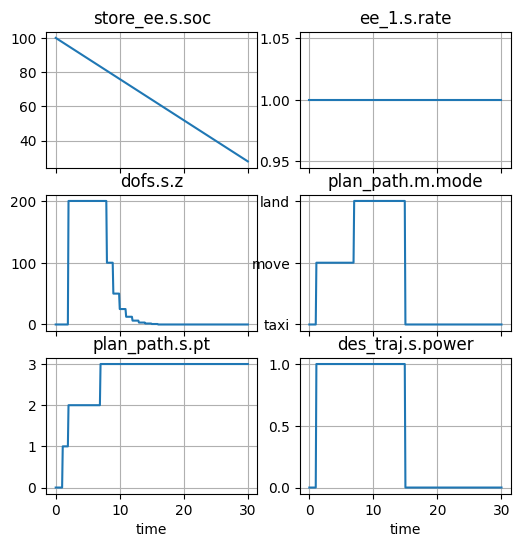

In [22]:
results_nom, hist_nom =propagate.nominal(mdl)
fig, axs = hist_nom.plot_line("store_ee.s.soc",
                            'ee_1.s.rate',
                            'dofs.s.z',
                            'plan_path.m.mode',
                            'plan_path.s.pt',
                            'des_traj.s.power')

As shown, the flight ends fairly quickly (in 10 minutes), with the drone successively proceeding through points in the flight plan.

We can also view this flightpath in 3-d space using `History.plot_trajectories`:

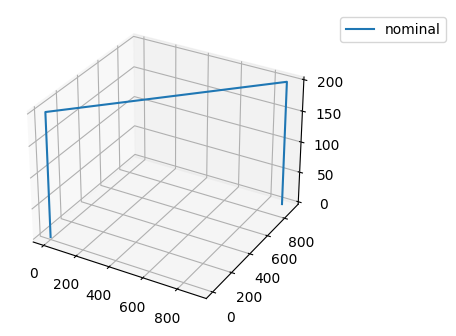

In [23]:
fig, ax = hist_nom.plot_trajectories('dofs.s.x', 'dofs.s.y', 'dofs.s.z')

Trajectory plots can be overlaid on top of environment plots. In this case, we defined the method `plot_env_with_traj` and `plot_env_with_traj3` for this case.

In [24]:
from drone_mdl_urban import plot_env_with_traj, plot_env_with_traj3d


(<Figure size 400x400 with 1 Axes>, <Axes3D: title={'center': 'trajectory'}>)

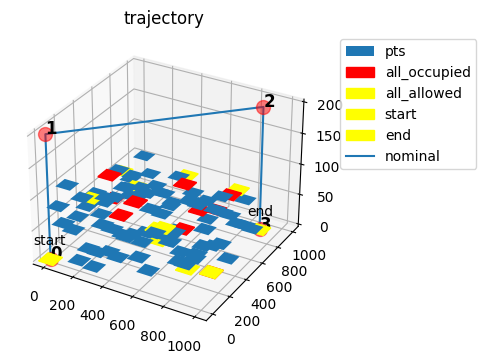

In [25]:
plot_env_with_traj3d(hist_nom, mdl)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'trajectory'}, xlabel='x', ylabel='y'>)

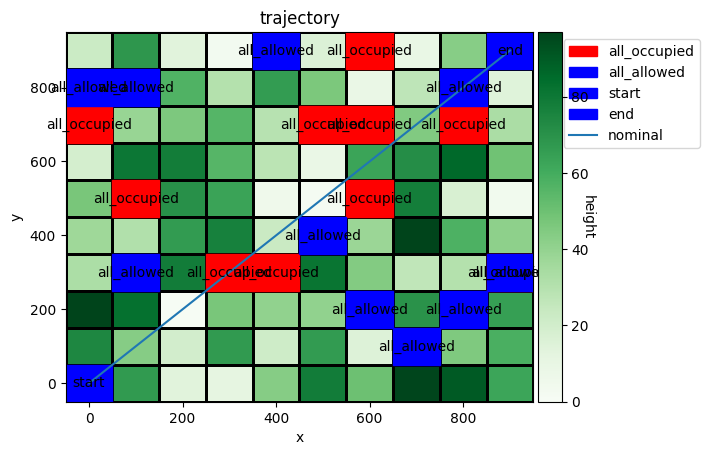

In [26]:
plot_env_with_traj(hist_nom, mdl)

As shown, this is a rather simple straight-line path. If we wanted a more complex scenario, we could make the path more complex by adding multiple destinations or planning the path based on allowed flight/landing locations.

As it is, we may also want to adjust the timestep/speed to get more resolution, since the drone only has a few discrete timesteps in the air.

The results for the simulation are:

In [27]:
results_nom

endclass: 
--rate:                              1.0
--cost:                              0.0
--expected cost:                     0.0
--repcost:                             0
--unsafe_flight_time:                  0
--body_strikes:                      0.0
--head_strikes:                      0.0
--property_restrictions:               0
--safecost:                          0.0
--landcost:                            0
--p_safety:                          0.0
--severities: {'hazardous': 0.0, 'minor': 1.0}

## Resilience model
A number of different faults have been implemented in the system.

For example, here we inject a mechanical fault in the left-rear rotor during flight:

In [28]:
mdl.fxns['affect_dof'].m.faultmodes

{'lf_short': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'lf_openc': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'lf_ctlup': Fault(prob=2.0000000000000003e-06, cost=500, phases={}, units='sim'),
 'lf_ctldn': Fault(prob=2.0000000000000003e-06, cost=500, phases={}, units='sim'),
 'lf_ctlbreak': Fault(prob=2.0000000000000003e-06, cost=1000, phases={}, units='sim'),
 'lf_mechbreak': Fault(prob=1.0000000000000002e-06, cost=500, phases={}, units='sim'),
 'lf_mechfriction': Fault(prob=5.000000000000001e-07, cost=500, phases={}, units='sim'),
 'lf_propwarp': Fault(prob=1.0000000000000001e-07, cost=200, phases={}, units='sim'),
 'lf_propstuck': Fault(prob=2.0000000000000002e-07, cost=200, phases={}, units='sim'),
 'lf_propbreak': Fault(prob=3.0000000000000004e-07, cost=200, phases={}, units='sim'),
 'lr_short': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'lr_openc': Fault(prob=1.0000000000000002e-06, cost=200, phas

In [29]:
results_fault, hist_fault =propagate.one_fault(mdl, "affect_dof", "lr_mechbreak", time=2.0)

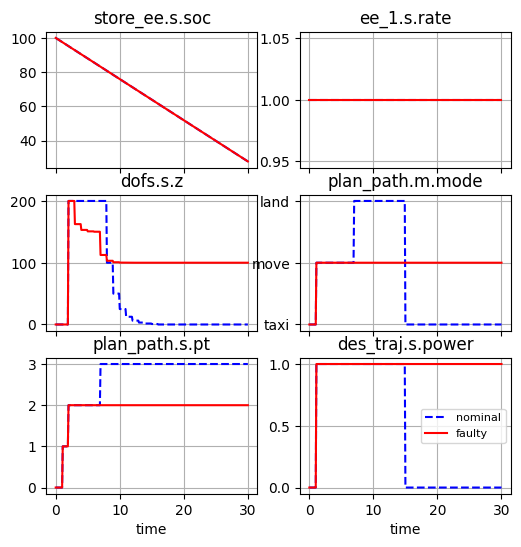

In [30]:
fig, axs = hist_fault.plot_line("store_ee.s.soc",
                                'ee_1.s.rate',
                                'dofs.s.z',
                                'plan_path.m.mode',
                                'plan_path.s.pt',
                                'des_traj.s.power')

(<Figure size 400x400 with 1 Axes>, <Axes3D: title={'center': 'trajectory'}>)

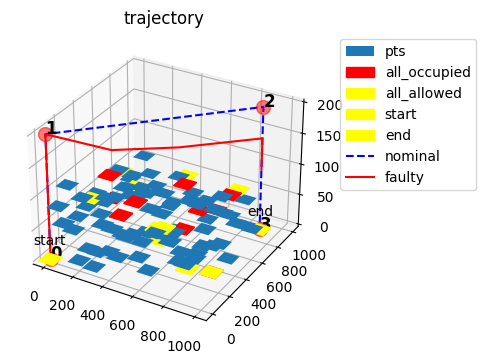

In [31]:
plot_env_with_traj3d(hist_fault, mdl)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'trajectory'}, xlabel='x', ylabel='y'>)

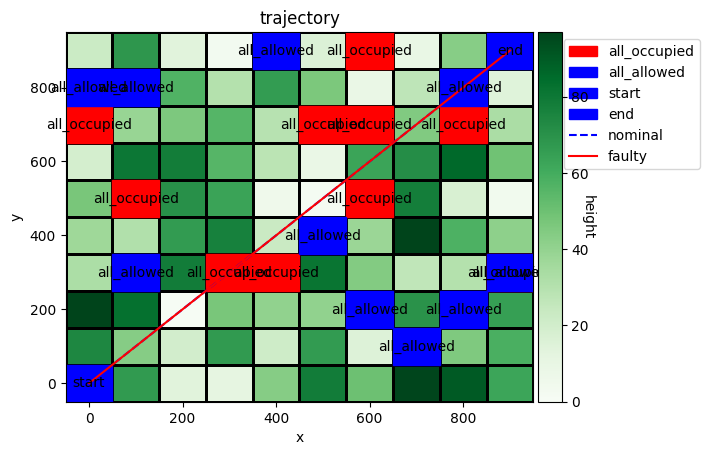

In [32]:
plot_env_with_traj(hist_fault, mdl)

In [33]:
results_fault

endclass.rate:    1.0000000000000002e-06
endclass.cost:                   28600.0
endclass.expected cost: 2860.0000000000005
endclass.repcost:                    500
endclass.unsafe_flight_time:         281
endclass.body_strikes:               0.0
endclass.head_strikes:               0.0
endclass.property_restrictions:        0
endclass.safecost:               28100.0
endclass.landcost:                     0
endclass.p_safety:                   0.0
endclass.severities: {'hazardous': 0.0, 'minor': 1.0000000000000002e-06}

Here we inject a large list of faults in the system and evaluate their relative consequences in terms of metrics calculated in find_classification:

In [34]:
from fmdtools.analyze.phases import PhaseMap, from_hist
phasemaps = from_hist(hist_nom, fxn_modephases=[])
phasemaps

{'manage_health': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 's1p1': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'store_ee': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'dist_ee': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'lf': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'lr': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'rf': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'rr': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'affect_dof': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'ctl_dof': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'plan_path': PhaseMap({'taxi': [0.0, 1.0], 'move': [1.1, 6.9], 'land': [7.0, 14.9], 'taxi1': [15.0, 30.0]}, {}),
 'hold_payload': PhaseMap({'nominal': [0.0, 30.0]}, {})}

In [35]:
from drone_mdl_urban import make_move_quad
move_quad=make_move_quad(hist_nom, phasemaps['plan_path'].phases['move'])
move_quad

{'samp': 'quadrature',
 'quad': {'nodes': [-0.1724137931034484, 0.8275862068965518],
  'weights': [1.0, 0.92]}}

In [36]:
from fmdtools.sim.sample import FaultDomain, FaultSample


fd = FaultDomain(mdl)
fd.add_all()

fs = FaultSample(fd, phasemap = phasemaps['plan_path'])
fs.add_fault_phases("move", method = "quad",
                    args=(move_quad['quad']['nodes'], move_quad['quad']['weights']))

fs

FaultSample of scenarios: 
 - manage_health_lostfunction_t4
 - manage_health_lostfunction_t7
 - store_ee_nocharge_t4
 - store_ee_nocharge_t7
 - store_ee_lowcharge_t4
 - store_ee_lowcharge_t7
 - store_ee_s1p1_short_t4
 - store_ee_s1p1_short_t7
 - store_ee_s1p1_degr_t4
 - store_ee_s1p1_degr_t7
 - ... (118 total)

In [37]:
endresults, hists = propagate.fault_sample(mdl, fs, staged=False)

SCENARIOS COMPLETE: 100%|██████████| 118/118 [00:52<00:00,  2.27it/s]


(<Figure size 400x400 with 1 Axes>, <Axes3D: title={'center': 'trajectory'}>)

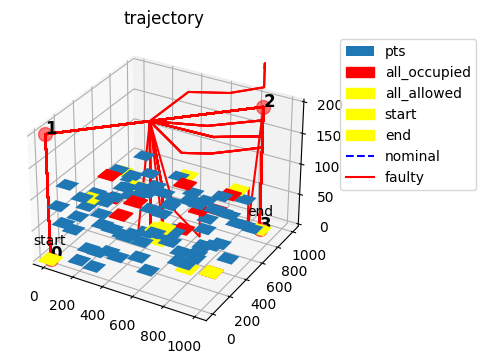

In [38]:
plot_env_with_traj3d(hists , mdl)

In [39]:
statsfmea = an.tabulate.FMEA(endresults, fs,
                            weight_metrics=['rate'],
                            avg_metrics=['unsafe_flight_time', 'cost', 'repcost',
                                         'landcost', 'body_strikes',
                                         'head_strikes', 'property_restrictions'])
fmeatab = statsfmea.as_table(sort_by="cost")
fmeatab

rate  unsafe_flight_time  \
plan_path     vision_lack_of_detection    5.666667e-02               246.0   
              vision_undesired_detection  5.666667e-02               110.5   
dist_ee       degr                        5.000000e-06               246.0   
              short                       3.000000e-06               246.0   
              break                       2.000000e-06               246.0   
affect_dof    rf_ctlbreak                 2.000000e-06               246.0   
              lf_ctlbreak                 2.000000e-06               246.0   
              rr_ctlbreak                 2.000000e-06               246.0   
              lr_ctlbreak                 2.000000e-06               246.0   
              lf_ctlup                    2.000000e-06               246.0   
              rf_ctlup                    2.000000e-06               246.0   
              rf_mechbreak                1.000000e-06               246.0   
              lf_openc                    1.000000e-06               246.0   
              rr_short                    1.000000e-06               246.0   
              lr_short                    1.000000e-06               246.0   
              rf_short                    1.000000e-06               246.0   
              lf_short                    1.000000e-06               246.0   
              lf_mechbreak                1.000000e-06               246.0   
              rf_openc                    1.000000e-06               246.0   
store_ee      s1p1_short                  6.800000e-07               246.0   
              s1p1_break                  6.800000e-07               246.0   
              s1p1_degr                   6.800000e-07               246.0   
              lowcharge                   1.586667e-06               246.0   
              nocharge                    4.533333e-07               246.0   
affect_dof    lf_ctldn                    2.000000e-06               246.0   
              rf_ctldn                    2.000000e-06               246.0   
              rr_ctlup                    2.000000e-06               246.0   
              lr_ctldn                    2.000000e-06               246.0   
              lr_ctlup                    2.000000e-06               246.0   
              rr_ctldn                    2.000000e-06               246.0   
              rf_propbreak                3.000000e-07               246.0   
              lf_propbreak                3.000000e-07               246.0   
plan_path     degloc                      2.720000e-07               246.0   
ctl_dof       degctl                      2.720000e-07               246.0   
affect_dof    lr_mechbreak                1.000000e-06               246.0   
              rr_mechbreak                1.000000e-06               246.0   
              rf_propstuck                2.000000e-07               246.0   
              lf_propstuck                2.000000e-07               246.0   
plan_path     noloc                       6.800000e-08               246.0   
ctl_dof       noctl                       6.800000e-08               246.0   
hold_payload  deform                      2.720000e-08               246.0   
              break                       6.800000e-09               246.0   
affect_dof    rr_openc                    1.000000e-06               246.0   
              lr_openc                    1.000000e-06               246.0   
              lr_propbreak                3.000000e-07               246.0   
              rr_propbreak                3.000000e-07               246.0   
manage_health lostfunction                1.700000e-09               246.0   
affect_dof    rr_propstuck                2.000000e-07               246.0   
              lr_propstuck                2.000000e-07               246.0   
store_ee      s1p1_nocharge               1.360000e-06               246.0   
affect_dof    rr_mechfriction             5.000000e-07               246